In [1]:
import pandas as pd
import random
import numpy as np

def read_sample_from(fname, n=1000):
    with open(fname,'r') as f:
        f_len = sum(1 for line in f) - 1
        
    skip = sorted(random.sample(range(1,f_len),f_len-n))
    
    return pd.read_csv(
        fname, 
        low_memory=False, usecols=range(27),
        skiprows=skip
    )

# df = read_sample_from('./data/311_Service_Requests_from_2011.csv', 100000)
df = pd.read_csv('./data/311_Service_Requests_from_2011.csv',  low_memory=False, usecols=range(27) )
print("File read complete: ", len(df), 'rows')

# A = df[['Agency','Borough','Unique Key','Complaint Type', 'Status','Created Date', 'Closed Date']]
A = df[df.Status == 'Closed']
A = A[A['Closed Date'].notnull()]
A['Closed Date'] = pd.to_datetime(A['Closed Date'], format='%m/%d/%Y %H:%M:%S %p')
A['Created Date'] = pd.to_datetime(A['Created Date'], format='%m/%d/%Y %H:%M:%S %p')
A['Response Time'] = (A['Closed Date'] - A['Created Date']) / np.timedelta64(1, 'h')
print("Response times by hour per agency")
print(A.groupby('Agency').agg({
    'Response Time': ['mean', 'median']
}).sort_values(('Response Time', 'mean')))

File read complete:  1917212 rows
Response times by hour per agency
       Response Time             
                mean       median
Agency                           
HRA         0.012222     0.012222
3-1-1       0.056184     0.010000
NYPD        3.649776     1.490833
ACS        22.801667    22.801667
DHS        92.577324    65.941528
DFTA       98.507973    48.456111
DOF       134.450214    69.172778
DOT       220.110077    33.542361
DEP       255.154511    29.033333
HPD       258.699415   144.000000
DSNY      288.977694    57.383333
NYCEM     345.216620   191.995139
DCA       385.664030   373.844167
FDNY      452.071201    39.230000
DOHMH     575.838200   312.000000
DOITT     809.082091   670.785556
TLC       841.567644   549.687222
DOE      1289.504946   158.536944
DOB      1999.577441   383.337222
DPR      3050.892103   151.911806
EDC      3099.661419  2379.057639


Summary of response times for Dept. of Sanitation
       Unique Key  X Coordinate (State Plane)  Y Coordinate (State Plane)  \
count   120462.00                   117175.00                   117175.00   
mean  20753653.68                  1005784.45                   197746.45   
std     813841.51                    27711.73                    30971.55   
min   19510895.00                   913859.00                   121152.00   
25%   20036025.25                   990690.00                   173354.00   
50%   20669986.50                  1005594.00                   194902.00   
75%   21484232.00                  1024260.50                   216994.00   
max   25459372.00                  1067220.00                   271876.00   

       Response Time  
count      120462.00  
mean          288.98  
std          4864.73  
min            -0.98  
25%            28.47  
50%            57.38  
75%           192.23  
max       1667045.16  


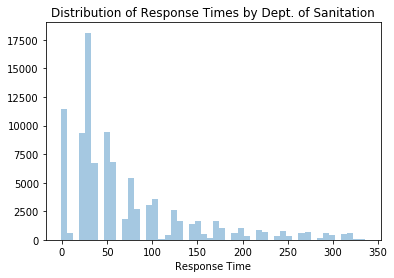

In [2]:
import seaborn as sns
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.2f' % x)

sanitation_responses = A[A.Agency == 'DSNY']
print("Summary of response times for Dept. of Sanitation")
print(sanitation_responses.describe())

# First, let's plot the values where response is below two weeks.

ax = sns.distplot(
    sanitation_responses[sanitation_responses['Response Time'] < 336]['Response Time'],
    kde=False
)
title = ax.set_title("Distribution of Response Times by Dept. of Sanitation")


In [3]:
sanitation_responses[['Complaint Type', 'Response Time']].groupby('Complaint Type').agg({
    'Response Time': ['mean', 'median']
})

Response Time        
                                           mean  median
Complaint Type                                         
Adopt-A-Basket                            72.46   71.95
Collection Truck Noise                    49.88   31.12
Derelict Bicycle                          60.93   34.19
Dirty Conditions                         248.18   97.18
Graffiti                                1383.19 1133.13
Litter Basket / Request                   52.61   33.87
Missed Collection (All Materials)         49.47   32.80
Other Enforcement                        110.71   50.31
Overflowing Litter Baskets                39.37   29.85
Recycling Enforcement                    411.58  154.27
Sanitation Condition                      48.07   32.00
Snow                                     149.09   57.23
Sweeping/Missed-Inadequate                45.15   31.50
Vacant Lot                               498.56  337.29

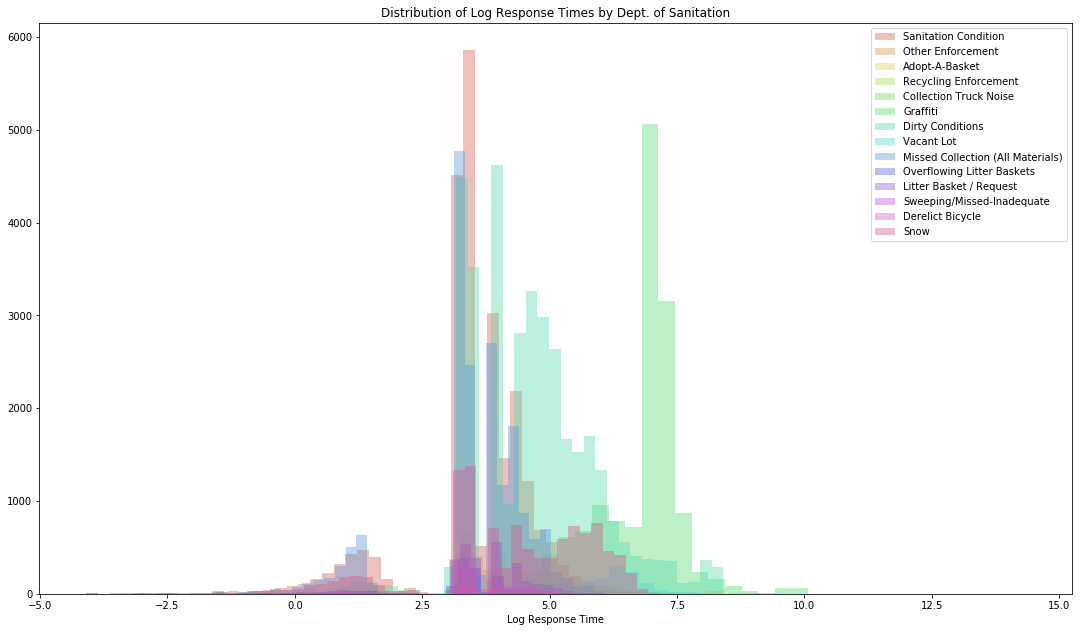

In [4]:
import matplotlib.pyplot as plt

complaint_types = list(set(sanitation_responses['Complaint Type']))
colors = sns.color_palette("hls", len(complaint_types))

for i in range(len(complaint_types)):
    complaint_type = complaint_types[i]
    
    response_gt_0 = sanitation_responses['Response Time'] > 0
    complaint_cat = sanitation_responses['Complaint Type'] == complaint_type 
    filtered = sanitation_responses[response_gt_0 & complaint_cat]

    log_values = np.log(filtered['Response Time'])
    log_values = log_values.rename('Log Response Time')
    ax = sns.distplot(log_values, kde=False, label=complaint_type, color=colors[i])

plt.legend()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
title = ax.set_title("Distribution of Log Response Times by Dept. of Sanitation")

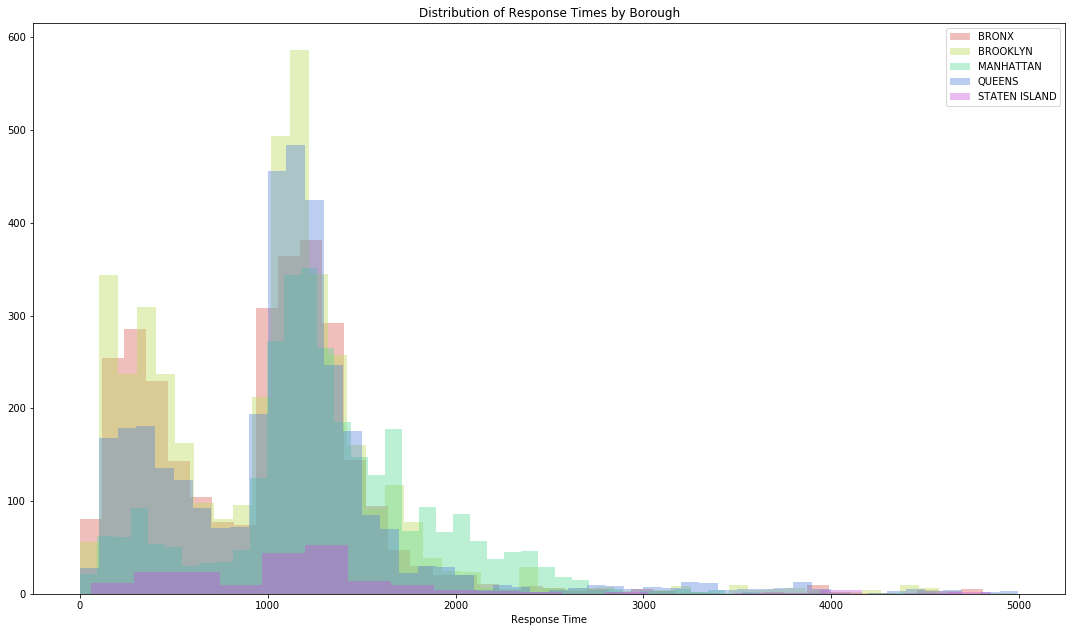

In [5]:
graffiti = sanitation_responses[sanitation_responses['Complaint Type'] == 'Graffiti']
boroughs = ['BRONX','BROOKLYN','MANHATTAN', 'QUEENS', 'STATEN ISLAND']
colors = sns.color_palette("hls", len(boroughs))

for i in range(len(boroughs)):
    borough = boroughs[i]
    borough_graffiti = graffiti['Borough'] == borough 
    remove_outliers = graffiti['Response Time'] < 5000
    filtered = graffiti[borough_graffiti & remove_outliers]
    ax = sns.distplot(filtered['Response Time'], kde=False, label=borough, color=colors[i])

plt.legend()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
title = ax.set_title("Distribution of Response Times by Borough")

In [6]:
import os
import folium

aggregated = graffiti.groupby(['Incident Zip']).median()[['Response Time']].reset_index()
                   #N       #W
NYC_COORDINATES = (40.7, -73.9)
nyc_geo = os.path.join('data', 'nyc-zip-code-tabulation-areas-polygons.json')
m = folium.Map(location=NYC_COORDINATES, zoom_start=10)
m.choropleth(
    geo_data=nyc_geo,
    name='choropleth',
    data=aggregated,
    columns=['Incident Zip', 'Response Time'],
    key_on='feature.properties.postalCode',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Median Response Time'
)
m


In [7]:
aggregated = graffiti.groupby(['Incident Zip']).count()[['Response Time']].reset_index()
m = folium.Map(location=NYC_COORDINATES, zoom_start=10)
m.choropleth(
    geo_data=nyc_geo,
    name='choropleth',
    data=aggregated,
    columns=['Incident Zip', 'Response Time'],
    key_on='feature.properties.postalCode',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Count of graffiti incidents'
)
m
